In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as plt
import seaborn as sns
import warnings
import altair as alt
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4000)

In [2]:
#read in data (these are the syndicator data post Carson's initial pre-processing)
b = pd.read_csv("syndicator_b.csv")
i = pd.read_csv("syndicator_i.csv")
g = pd.read_csv("syndicator_g.csv")

#### Syndicator B 

In [3]:
cols = ["totalcost","con_type","units_n","yr_pis","sources_n"]

def clean_syndicator_cols(df,cols,df_name):
    """
    Grab only cols i need to find avg unit cost, clean numeric cols and convert to ints 
    """
    df = df[cols]
    df[cols] = df[cols].replace({'\$': '', ',': ''}, regex=True)
    df[["totalcost","units_n"]] = df[["totalcost","units_n"]].astype(int)
    df["flag"] = df_name
    return df 

In [4]:
#clean strings and turn strings into ints 
b_units_cost = clean_syndicator_cols(b,cols,"b")
b_units_cost.head()

,totalcost,con_type,units_n,yr_pis,sources_n,flag
0,32481257,New,75,2014,6.00,b
1,5333498,New,24,2015,3.00,b
2,6849238,New,44,2013,2.00,b
3,7183151,New,72,2015,3.00,b
4,5957537,New,56,2014,3.00,b


#### Syndicator i 

In [5]:
i_units_cost = clean_syndicator_cols(i,cols,"i")
i_units_cost.head()

,totalcost,con_type,units_n,yr_pis,sources_n,flag
0,16715361,New,98,2015,4,i
1,8541173,Rehab-Around,100,2014,8,i
2,22461237,New,80,2014,3,i
3,73044023,New,136,2009,8,i
4,23949900,New,65,2011,5,i


#### Syndicator G 


In [6]:
g = g.dropna()
g_units_cost = clean_syndicator_cols(g,cols,"g")
g_units_cost.head()

,totalcost,con_type,units_n,yr_pis,sources_n,flag
0,69809586,New Construction,136,2009.00,4.00,g
1,39190669,Rehab,137,2018.00,7.00,g
2,49178710,New Construction,107,2010.00,3.00,g
3,21037569,New Construction,142,2010.00,4.00,g
4,39964744,New Construction,240,2017.00,4.00,g


### Concat together and clean up difference between new and rehab

In [7]:
unit_cost = pd.concat([b_units_cost,i_units_cost,g_units_cost])

In [8]:
def clean_up_for_charts(df):
    #find average cost per unit 
    df["Cost Per Unit"] = df["totalcost"].astype(int) / df["units_n"].astype(int)
    #make yr_pis an int, and substract two years for con_yr per discussion 
    df["Year"] = df["yr_pis"].astype(int) - 2
    df = df.drop(columns={"yr_pis"})
    #clean up name 
    df = df.rename(columns = {"sources_n":"Number of Sources"})
    return df 

In [9]:
unit_cost = clean_up_for_charts(unit_cost)

In [10]:
#clearly need to standize con_type 
unit_cost.con_type.value_counts()

 New                151
New                 143
 Rehab              107
New Construction    101
Rehab-Around         71
Rehab                29
Rehab - TIP          19
Gut Rehab            12
 Historic Rehab      11
 New/Rehab            6
Acq/Rehab             2
Adaptive              1
Name: con_type, dtype: int64

In [11]:
#drop when it says both new and rehab as unclear what these are and there are few
#and then standarize to just new and rehab
unit_cost = unit_cost[~unit_cost.con_type.isin([' New/Rehab ',"New/Rehab","Acq/Rehab","New Construction & Rehab - TIP","New Construction & Rehab"])]

In [12]:
def categorize_new(x):
    if "New" in x:
        return "New Construction"
    else:
        return "Rehab"
#label new or rehab 
unit_cost["con_type_clean"] = unit_cost.con_type.apply(lambda x: categorize_new(x))                                                                    

### Filtering dataset to new construction only as the main indicator of 9% vs 4% leaves us with 395 observations 

In [13]:
potential_9_new_construction = unit_cost[unit_cost["con_type_clean"] == "New Construction"]

In [14]:
len(potential_9_new_construction)

395

In [15]:
#only one observation in 2019, going to drop as its value is 10 for source count, a clear outlier
potential_9_new_construction.groupby("Year").count()

,totalcost,con_type,units_n,Number of Sources,flag,Cost Per Unit,con_type_clean
Year,,,,,,,
2003,3,3,3,3,3,3,3
2004,8,8,8,8,8,8,8
2005,12,12,12,12,12,12,12
2006,33,33,33,33,33,33,33
2007,35,35,35,35,35,35,35
2008,23,23,23,23,23,23,23
2009,14,14,14,14,14,14,14
2010,15,15,15,15,15,15,15
2011,28,28,28,28,28,28,28


In [16]:
#drop 2019
potential_9_new_construction = potential_9_new_construction[potential_9_new_construction.Year != 2019]

#### Note: if you add  ci=False to the sns.lineplot function you can remove the confidence intevals 


Text(0.5, 1.0, 'New Construction Syndicator Projects: Number of Sources Over Time')

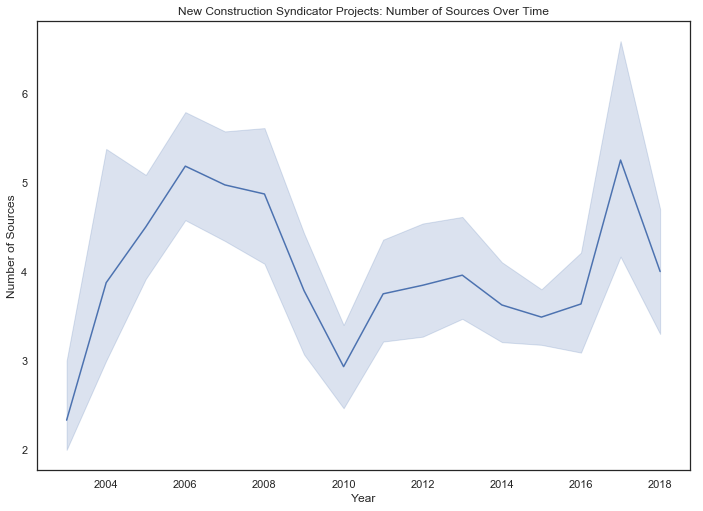

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style='white') 
sns.lineplot(x="Year", y="Number of Sources", data=potential_9_new_construction).set_title('New Construction Syndicator Projects: Number of Sources Over Time')
#plt.ticklabel_format(style='plain', axis='y')

Text(0.5, 1.0, 'New Construction Syndicator Projects: Cost Per Unit Over Time')

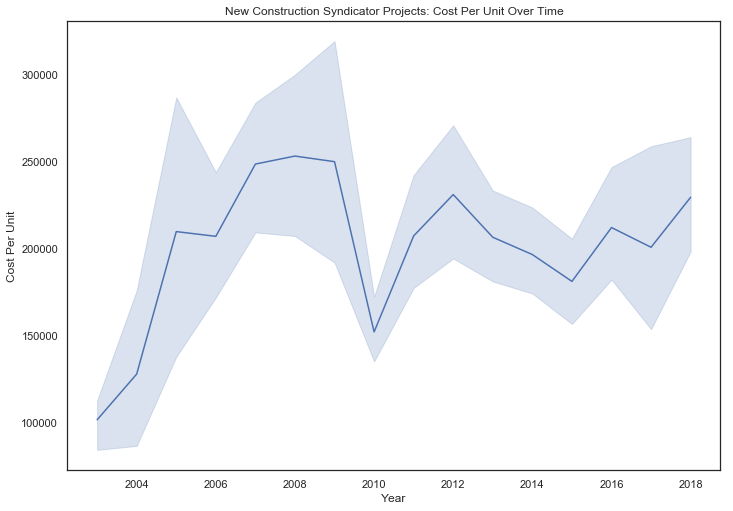

In [18]:
#not CPI adjusted, but don't think we will use this chart 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style='white') 
sns.lineplot(x="Year", y="Cost Per Unit", data=potential_9_new_construction).set_title('New Construction Syndicator Projects: Cost Per Unit Over Time')
#plt.ticklabel_format(style='plain', axis='y')

### Syndicator data where the debt to equity ratio is over 50%, implying a 9% project 

In [19]:
b = b.rename(columns={"equity_lif":"equity_net"}) #make measues of equity overlap 
debt_to_equity = pd.concat([b,i])

In [20]:
#used below to label equity percentages as either likley 9% or 4% 
def is_nine_percent(x):
    if x > .5:
        return "Likely 9% Project"
    else:
        return "Likely 4% Project"

In [21]:
#turn strings into ints to find equity ratio
cols = ['totalcost', 'equity_net']

# pass them to df.replace(), specifying each char and it's replacement:
debt_to_equity[cols] = debt_to_equity[cols].replace({'\$': '', ',': ''}, regex=True)

In [22]:
debt_to_equity["equity_ratio"] = debt_to_equity["equity_net"].astype(int) / debt_to_equity["totalcost"].astype(int)
debt_to_equity["project_type"] = debt_to_equity.equity_ratio.apply(lambda x: is_nine_percent(x))

In [23]:
#there are 315 likely 9% projects measured this way 
debt_to_equity["project_type"].value_counts()

Likely 9% Project    315
Likely 4% Project    187
Name: project_type, dtype: int64

In [24]:
debt_to_equity = debt_to_equity[debt_to_equity["project_type"]=="Likely 9% Project"]

In [25]:
#calc earlier function to clean up data
debt_to_equity = clean_up_for_charts(debt_to_equity)

In [26]:
#worth dropping everything before 2004 and after 2018 
debt_to_equity.groupby("Year").count()

,Unnamed: 0,id,totalcost,constcost,hardcost,acqucost,landcost,equity_net,equity_lis,con_type,Number of Sources,lien1,lien1type,lien2,lien2type,lien3,lien3type,lien4,lien4type,lien5,lien5type,lien6,lien6type,lien7,lien7type,lien8,lien8type,lien9,lien9type,lien10,lien10type,acqudate,con_stdate,concomdate,stabdate,units_n,units_li,units_ot,zipcode,build_n,sqft,tpop,state,df,city,sqft_rent,source1type,source1,source2type,source2,source3type,source3,source4type,source4,source5type,source5,source6type,source6,source7type,source7,source8type,source8,source9type,source9,source10type,source10,source11type,source11,loi_date,closedate,equity_ratio,project_type,Cost Per Unit
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2002,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
2003,2,2,2,0,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,2,0,0,2,2,2,2,0,2,2,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2
2004,7,7,7,0,0,0,0,7,0,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,0,0,7,0,0,7,7,7,7,1,7,7,7,7,7,7,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7
2005,4,4,4,0,0,0,0,4,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,0,0,4,0,0,4,4,4,4,4,4,4,4,4,4,4,3,3,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4
2006,20,20,20,0,0,0,0,20,0,20,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,20,20,20,0,0,20,0,0,20,20,20,20,18,20,20,20,20,20,20,12,12,8,8,4,4,4,4,4,4,2,2,0,0,0,0,0,20,20,20,20
2007,14,14,14,0,0,0,0,14,0,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,14,14,14,0,0,14,0,0,14,14,14,14,14,14,14,14,14,14,14,8,8,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,14,14,14,14
2008,3,3,3,0,0,0,0,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,0,0,3,0,0,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3
2009,2,2,2,0,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,2,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,2,2,2,2


In [27]:
#drop years noted above
debt_to_equity = debt_to_equity[debt_to_equity.Year.isin(np.arange(2004,2019))]

Text(0.5, 1.0, 'Syndicator Data with > 50% Debt to Equity Threshold: Number of Sources Over Time')

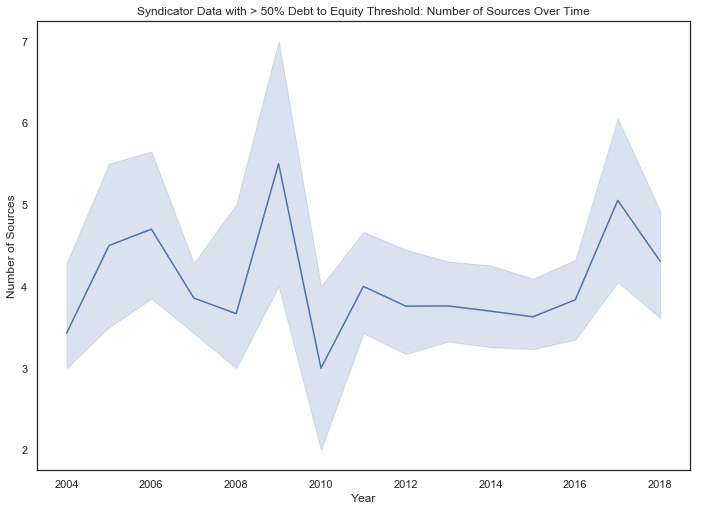

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style='white') 

sns.lineplot(x="Year", y="Number of Sources", data=debt_to_equity).set_title('Syndicator Data with > 50% Debt to Equity Threshold: Number of Sources Over Time')

Text(0.5, 1.0, 'Syndicator 50% Debt to Equity Threshold: Cost Per Unit Over Time')

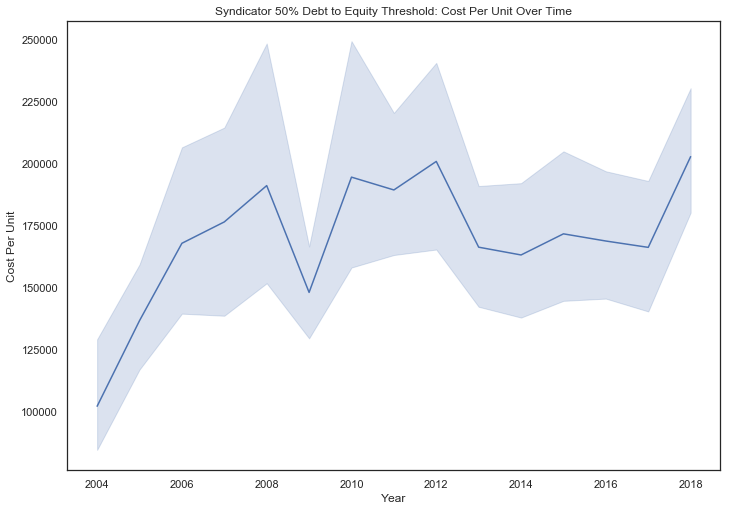

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style='white') 

sns.lineplot(x="Year", y="Cost Per Unit", data=debt_to_equity).set_title('Syndicator 50% Debt to Equity Threshold: Cost Per Unit Over Time')
